# Return Period for La ReUnion Best Track Data

This notebook reviews the return period using La ReUnion Best Track data

In [16]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from src.datasources import codab, rsmc
from src import constants

In [18]:
save_dir = rsmc.DATA_DIR / "public" / "exploration" / "moz" / "ecmwf_hindcast"

<Axes: >

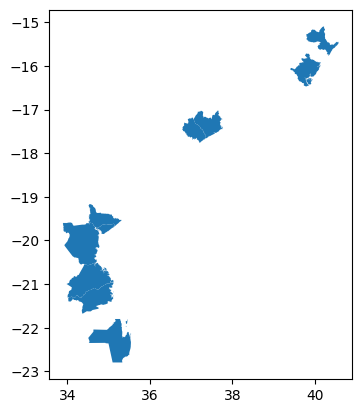

In [19]:
from pathlib import Path
import os

AA_DATA_DIR = os.getenv("AA_DATA_DIR")
ADMS2 = constants.ADMS2
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)
gdf_adm2 = gpd.read_file(adm2_path)
gdf_adm2_sel = gdf_adm2[gdf_adm2.ADM2_PT.isin(ADMS2)]
gdf_adm2_sel.plot()

<Axes: >

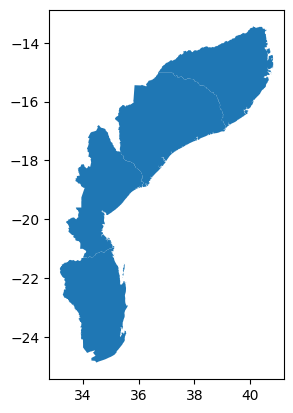

In [20]:
adm = codab.load_codab(aoi_only=True)
adm.plot()

In [21]:
adm2_setting = False
if adm2_setting:
    adm = gdf_adm2_sel.copy()

In [22]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    rsmc.DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

In [23]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(
    lambda x: -x if x > 0 else x
)

In [24]:
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)

In [26]:
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, adm, how="inner", predicate="intersects"
)
cyclone_tracks_sel_adm2 = gpd.sjoin(
    cyclone_tracks_gdf, gdf_adm2_sel, how="inner", predicate="intersects"
)

<Axes: >

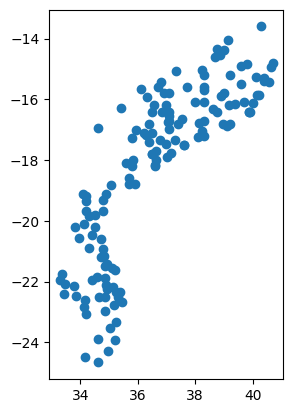

In [27]:
cyclone_tracks_sel.plot()

In [28]:
cyclone_tracks_sel["Name"].unique()

array(['FILAO', 'DESSILIA', 'NADIA', 'BONITA', 'LISETTE', 'A19798',
       'ASTRIDE', 'ELINE', 'GLORIA', 'HUDAH', 'DELFINA', 'JAPHET',
       '720052006', 'FAVIO', 'JAYA', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA',
       'HARUNA', 'DELIWE', '920132014', 'GUITO', 'HELLEN', 'CHEDZA',
       'DINEO', '420172018', 'DESMOND', 'IDAI', 'KENNETH', 'CHALANE',
       'ELOISE', 'GUAMBE', 'ANA', 'DUMAKO', 'GOMBE', 'JASMINE', 'FREDDY'],
      dtype=object)

In [29]:
def calculate_storm_return_period_la_reunion(
    df, wind_speed_kmh, start_year, num_storms_year
):
    from datetime import datetime
    import math

    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Ensure UTC is formatted as a two-digit hour
    df["UTC"] = df["UTC"].apply(lambda x: f"{int(x):02}")
    # Create a datetime column from separate date and time columns
    df["ISO_TIME"] = pd.to_datetime(
        df[["Year", "Month", "Day", "UTC"]].astype(str).agg(" ".join, axis=1)
    )

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].dt.year

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[
        (df["year"] >= start_year) & (df["Max wind (kt)"] >= speed_knots)
    ]

    # Count unique storms
    unique_storms = df_filtered["Name"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2023 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh} km/h is 1-in-{round(combined_return_period, 1)} years."
    )

    # Calculate return periods for each administrative region
    # admin_return_periods = {}

    # grouped = df_filtered.groupby("ADM1_PT")
    # for admin, group in grouped:
    #    admin_unique_storms = group["Name"].nunique()
    #    admin_return_period = yr_len / admin_unique_storms
    #    admin_return_periods[admin] = admin_return_period

    #    print(
    #        f"The return period of storms over {wind_speed_kmh} km/h in {admin} is 1-in-{round(admin_return_period, 1)} years."
    #    )

    # Calculate probabilities using the Poisson distribution
    ave_num = unique_storms / yr_len
    expected_probability = (
        math.exp(-ave_num)
        * (ave_num**num_storms_year)
        / math.factorial(num_storms_year)
    )
    print(
        f"The probability of exactly {num_storms_year} storms making landfall in an average year is {round(expected_probability * 100, 1)}%."
    )
    print(
        f"The return period of exactly {num_storms_year} storms making landfall in an average year is 1-in-{round(1 / expected_probability, 1)} years."
    )

In [34]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-3.4 years.
The probability of exactly 1 storms making landfall in an average year is 22.0%.
The return period of exactly 1 storms making landfall in an average year is 1-in-4.5 years.


In [32]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89 km/h is 1-in-5.5 years.
The probability of exactly 1 storms making landfall in an average year is 15.2%.
The return period of exactly 1 storms making landfall in an average year is 1-in-6.6 years.


In [31]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-4.0 years.
The probability of exactly 1 storms making landfall in an average year is 19.5%.
The return period of exactly 1 storms making landfall in an average year is 1-in-5.1 years.


In [35]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_adm2,
    wind_speed_kmh=constants.THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118 km/h is 1-in-7.3 years.
The probability of exactly 1 storms making landfall in an average year is 11.9%.
The return period of exactly 1 storms making landfall in an average year is 1-in-8.4 years.
